# Assignment 1
## Getting started with SED fitting & error estimation


This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Error Estimation module. 

The SETUP section is designed to be done first, to familarize yourself with the data and the details of SED fitting. Section 1 is shorter to account for this. You should be able to finish Section 1 after January 26th, Section 2 after February 2nd, and Section 3 after February 9th. You can work on this assignment during the lab hours, as well as in your own time - and feel free to ask the instructors questions!

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. Feel free to write any commonly used functions in a separate module and import them here if you like.

# Section 0
## Setup

First, we need to set up the SED fitting project, install Prospector, and make sure we can run Prospector. This section is written assuming that you are using a Unix-based system (including MacOS). If you are using Windows, consider installing and using [Windows Subsystem for Linux, or WSL](https://learn.microsoft.com/en-us/training/modules/wsl-introduction/).

1. Download the data from [here](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html) (both the input and output catalog). <br>
   The data comes from [Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract), who used MAGPHYS (another SED fitting code) to fit the photometry stored in the input file and obtain stellar masses / ages / etc. stored in the output file. <br>
   > Be careful of where you store these files. If you store them in a random place in this repository, they will get pushed to Git alongside your changes. The files are heavy, which will cause problems downstream. We suggest placing your files in `projects/sed-fitting/data` folder (for Chang catalogs) and `projects/sed-fitting/output` folder (for your own Prospector output files). These folders are added in the `.gitignore` file in the root, and so anything in these folders will be ignored by Git.
   
2. Install [Prospector](https://github.com/bd-j/prospector)
   > We found this easiest to do using the [conda script](https://github.com/bd-j/prospector/blob/main/conda_install.sh) provided: download the script somewhere on your PC and run `bash conda_install.sh`. Again, best not to do this inside the Git repository as the bash script will download several large libraries. If you are feeling brave, you can try doing it from this repository, but first make sure to add the libraries to `.gitignore`. <br>
   > Make sure to follow the instructions from `conda_install.sh`: add SPS_HOME to your `~/.bashrc` file as your terminal says.<br>
   > This bash script will create a new conda environment, `prospector`, which you can run using `conda activate prospector`.
    <br><br>

3. Fix a Prospector + NumPy >= 1.20 issue (you might not need this)<br>
   Run the following cell:

In [1]:
import numpy as np
print(np.__version__)

1.26.3


If the version is greater than 1.20.0, you will need to fix a library in Prospector to make it compatible with a later NumPy. There is a file `write_results.py` in the project library. Copy it to your Prospector installation location within your conda environment, it should be something like `/home/[username]/[your conda installation]/envs/prospector/lib/[your python version]/site-packages/prospect/io`

4. Install any other Python libraries<br>Since we have made a new environment, it will only have prospector and its dependancies installed. We still need to install other useful Python libraries in the new environment. 
   > We listed the libraries you will need in `requirements.txt`.<br>
   > First, run `conda activate prospector` to make sure you are using the new environment. <br>
   > Then, you can install all required libraries simply using `pip install -r requirements.txt`


## Test Prospector

We have provided a notebook, Prospector Example, that gives step-by-step instructions for loading in the photometric data for one galaxy and running Prospector to get a simple fit to that galaxy's SED. If you have any questions, you can either ask us, or consult the [Prospector documentation](https://prospect.readthedocs.io/en/latest/) that has explanations of all the different parameters, models, and use cases.

#### Step 1
Open the example notebook and run it completely without changing anything. <br> (This is to make sure everything is installed right)

#### Step 2
Try to change some fitting parameters: you can try a different galaxy, play around with different priors, try a different star formation model, or a different sampling technique.

What did you try? What was different between the fits?

#### Step 3
Try running Prospector through a command line.

Re-running a notebook each time is impractical, so to fit several galaxies, it's easier to write everything as a Python script we can run from the command line. We wrote a Python script for you, `assignment_params.py`. 

It has a few command line arguments. You can see the meaning of the different arguments by running

     python assignment_params.py --help

Try running this line in your command line to ensure that Prospector works fine and produce a fit for a test galaxy.

> Note: if you stored your data files elsewhere, you will need to change the path to the input catalog on Line 200.

#### Step 4

Here we load in the data, select one random set of parameters $\vec{\theta}$, and the optimized set of parameters $\vec{\theta}_{max}$. We also generate an SED from these two models, and a full spectroscopic model.

In [1]:
import prospect.io.read_results as reader
import matplotlib.pyplot as plt
import numpy as np

Loading in data:

In [2]:
file_name = '/mnt/c/Users/guill/Desktop/GitHub/UWAstroStats/projects/sed-fitting/output/test_24Feb08-16.30_result.h5'
#file_name = '../output/test_24Jan14-17.54_result.h5' #### Change this to your filename!
res, obs, model = reader.results_from(file_name)
results_type = "emcee" # | "dynesty"
sps = reader.get_sps(res)

Selecting a random and the best models:

In [3]:
# To draw a random chain
randint = np.random.randint

# Selecting a random (not best) parameter vector from MCMC
if results_type == "emcee":
    nwalkers, niter = 2, 2
    theta = res['chain'][randint(nwalkers), randint(niter)]
else:
    theta = res["chain"][randint(len(res["chain"]))]

# Index of the best chain / parameter vector
imax = np.argmax(res['lnprobability'])

# Selecting the best parameter vector
if results_type == "emcee":
    i, j = np.unravel_index(imax, res['lnprobability'].shape)
    theta_max = res['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = res["chain"][imax, :]
    thin = 1

Getting x-values: the central wavelengths of our filters, and changing them to restframe

In [4]:
# cosmological redshifting
a = 1.0 + model.params.get('zred', 0.0) 

# photometric effective wavelengths
wphot = obs["phot_wave"]

# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them

# Find bounds 
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()*10

Create the SEDs for the random and the best fit models. The SED photometry is stored in `mspec` (first returned value) and the full spectrum is in `mphot` (second returned value).

In [5]:
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

Plot the fit and the model:

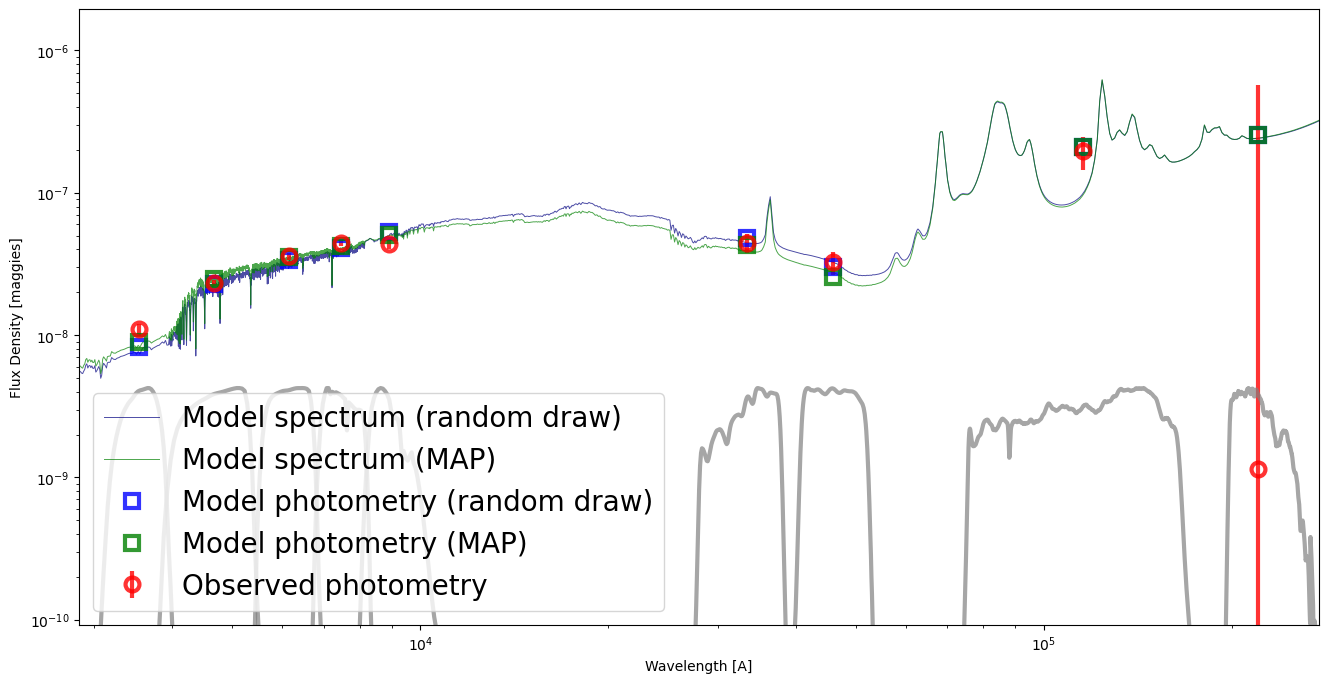

In [6]:
# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

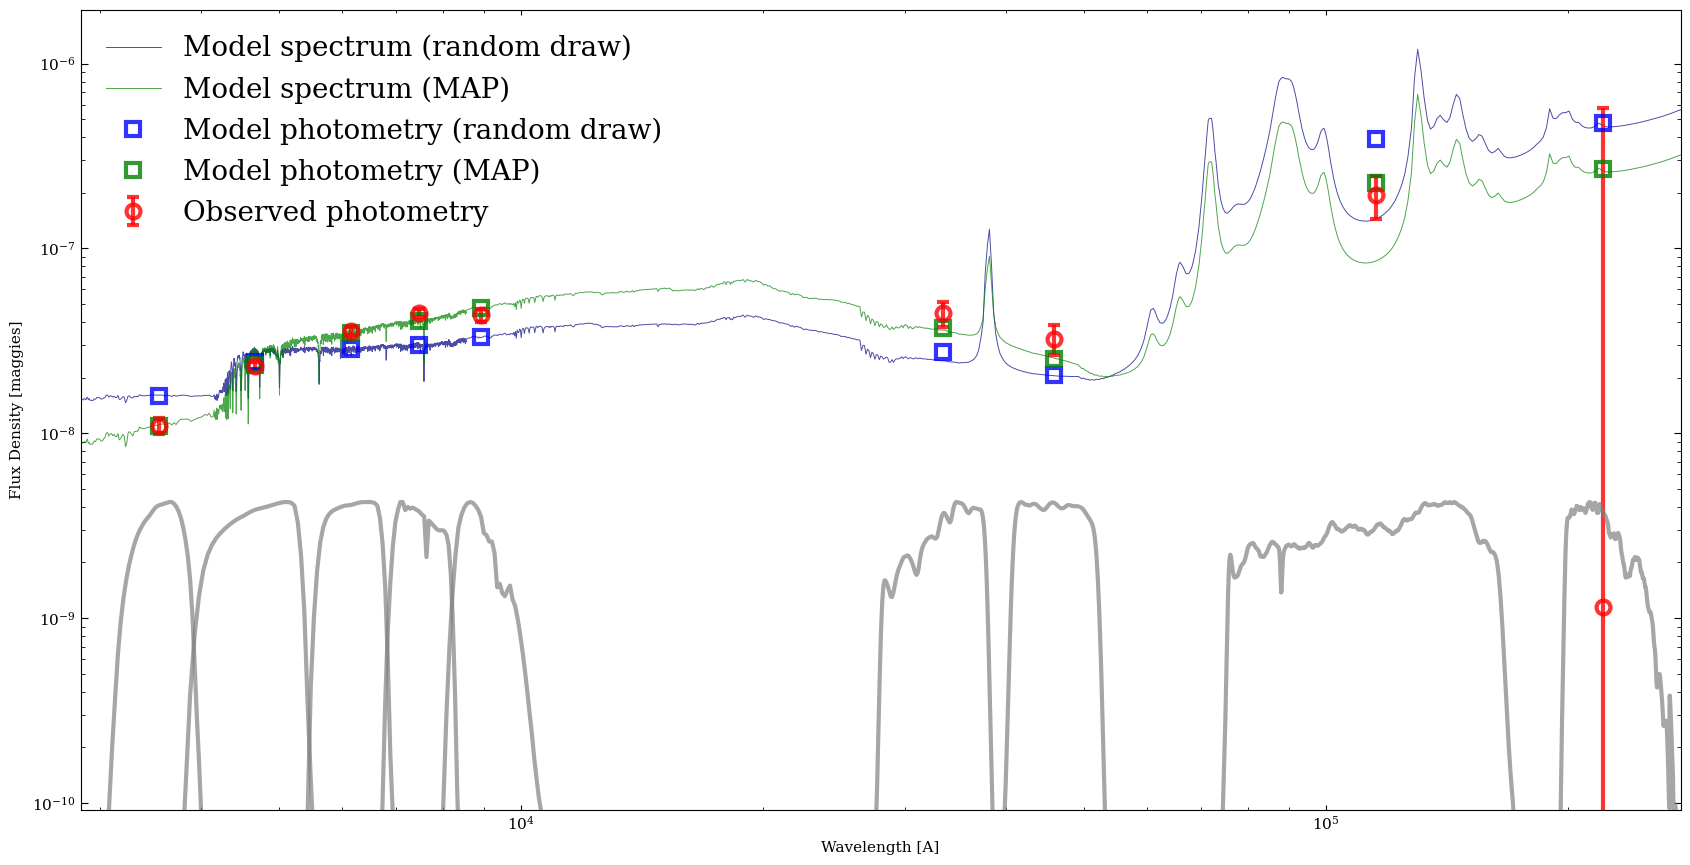

In [7]:
# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

> Note: if you want to make these plots several times for different galaxies / fits, it may be useful to save this code as a separate Python file, e.g. `plotting.py`. You can then import these functions in this notebook or elsewhere without re-defining them.

#### Step 5

The code below loads in the table containing the photometry of all galaxies as a [Pandas DataFrame](https://pandas.pydata.org/). Select a sample of galaxies to run Prospector on. 

In [8]:
from astropy.table import Table
from astropy.io import fits
with fits.open('../data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

df.head()

,id,ra,dec,redshift,PLATE,MJD,FIBERID,designation,flux0_u,flux0_u_e,...,flux_w2_e,flux_w3,flux_w3_e,flux_w4,flux_w4_e,extin_u,extin_g,extin_r,extin_i,extin_z
0,3,337.450310,1.266134,0.088372,376,52143,404,J222948.07+011558.1,0.000031,0.000003,...,0.000049,4.172000e-07,0.000209,0.000002,0.001187,0.341327,0.265960,0.183990,0.136724,0.101698
1,5,338.115522,1.270146,0.163800,376,52143,567,J223227.69+011612.6,0.000011,0.000004,...,0.000111,9.851000e-07,0.000493,0.000004,0.001883,0.368063,0.286793,0.198402,0.147434,0.109664
2,8,341.101481,1.266255,0.143369,378,52146,404,J224424.38+011558.3,0.000017,0.000003,...,0.000039,1.013700e-06,0.000507,0.000008,0.003856,0.337630,0.263079,0.181997,0.135243,0.100596
3,12,341.870909,1.267913,0.275242,378,52146,567,J224729.01+011604.3,0.000007,0.000003,...,0.000106,9.999000e+00,9.999000,0.000009,0.004526,0.358145,0.279064,0.193055,0.143461,0.106709
4,14,342.686706,1.270160,0.089104,676,52178,373,,0.000031,0.000003,...,9.999000,9.999000e+00,9.999000,9.999000,9.999000,0.362289,0.282293,0.195289,0.145121,0.107943


**Optional:** how did you choose your set of galaxies? It's okay if they are all random, but if you want, you can try to choose a sample you find interesting.

In [11]:
# Space to select a sample of N galaxies, answer the question, or do something else. 
# If you are sampling randomly, you can use df.sample()!
# sample = df.sample(5)

Don't forget to save your sample or at least note down the id's you used!

#### Step 6

Run Prospector on your chosen sample. Feel free to use the default code we provided, or try your own fitting / modelling parameters.

> Hint: you can use Jupyter to run something from the command line using `!`. This allows you to pass variables from your Jupyter environment as arguments in curly braces `{...}`. For example, you could run:

    ! python assignment_params.py --objid={your_index} --optimize --emcee 

> If you are using Python without Jupyter, you can't use `!`, but you can use [subprocess.run()](https://docs.python.org/3/library/subprocess.html#subprocess.run) function.

#### Step 7

The photometry of the galaxy changes based on how far away it is: galaxies further away are fainter, and their SED shifts more towards red wavelengths. This is one of the challenges of SED fitting: it's hard to break the degeneracy between galaxies that are red because they are intrinsically red (older stars), and galaxies that are red because they are far away. 

By default, we give Prospector a *known* spectroscopic redshift for each galaxy. This means that it is not fitting one of the important degenarate parameters.

However, obtaining a spectroscopic redshift is difficult, as it requires measuring a galaxy spectrum - simple photometry is way easier. The galaxies we used in this project all have spectroscopy, but there are millions of galaxies that do not. For those objects, we need to fit the SED *and* redshift simultaneously.

Let's imagine that we don't know the redshift of our objects. For your sample, re-run the Prospector fits by setting redshift as one of the free parameters. You can change the redshift from fixed to free by using `--var-redshift` argument when calling `assignment_params.py`. 

In [13]:
from tqdm.notebook import tqdm
for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    outname = f'gal{idx}_emcee_varz'
    # Uncomment this to run
    # ! python assignment_params.py --objid={idx} --optimize --emcee --outfile={outname} --var_redshift

  0%|          | 0/5 [00:00<?, ?it/s]

# Section 1

#### Step 1: Goodness-of-Fit

Choose one of your galaxies, load in the data, and plot the original data and the best fit with error bars.

Compute the goodness-of-fit ($\chi^2$) of your fit. 

> Note: Prospector assumes the magnitudes are independent so you can to, but we'll come back to this later

In [14]:
# Space to work

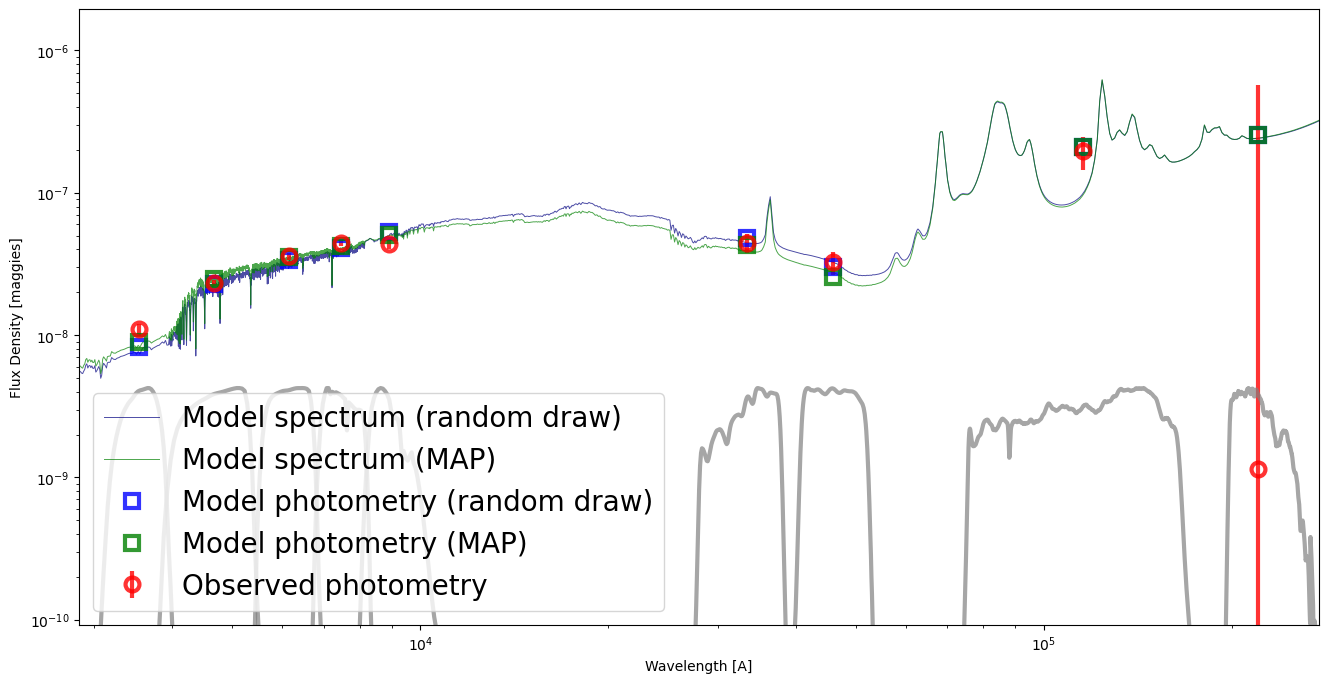

In [7]:
# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

# plt.ylim(1e-9, 1e-6)

In [8]:
from scipy.stats import chisquare

In [13]:
def chi2(obs, exp):
    return np.sum((obs-exp)**2/exp)
print(chi2(obs['maggies'],mphot_map))

2.5624929674302415e-07


Is your goodness-of-fit reasonable? Why / why not?

#### Step 2: Fit results

What are the best fit, mean, and $1\sigma$, $2\sigma$, $3\sigma$ confidence intervals for each of the constrained parameters?

In [57]:
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


In [51]:
#print(result['bestfit']['parameter'])
#print(result['model_params'])
#print(result['model_params'][0]['name'])
values = []
for i in range(6):
    val = result['bestfit']['parameter'][i]
    values.append(val)

names = []
for i in range(6):
    name = result['model_params'][i]['name']
    names.append(name)

for i in range(6):
    print(f'{names[i]}: {values[i]}')


zred: 0.06760284335647364
mass: 2236134328.289496
logzsol: -0.22793155141957838
dust2: 0.5005604042748655
sfh: 1.9779011192364466
tage: 0.5250331727929165


In [61]:
for i in range(6):
    print(names[i])
    flat = result['chain'][:,:,i].flatten()
    print('Mean: ' +str(np.mean(flat)))
    print('1, 2, 3 Upper Sigma: ' +str(np.percentile(flat, [0.84, 97.5, 99.85])))
    print('1, 2, 3 Lower Sigma: ' +str(np.percentile(flat, [0.15, 2.5, 16])))

#print(np.shape(result['chain'][:,:,0]))


zred
Mean: 0.05870788965893637
1, 2, 3 Upper Sigma: [0.02094115 0.10945573 0.17534935]
1, 2, 3 Lower Sigma: [0.01288038 0.02532943 0.04099774]
mass
Mean: 2601274797.940295
1, 2, 3 Upper Sigma: [4.03586197e+08 7.16059352e+09 1.76704614e+10]
1, 2, 3 Lower Sigma: [1.45740481e+08 5.52130617e+08 1.34001521e+09]
logzsol
Mean: -0.5302476472656571
1, 2, 3 Upper Sigma: [-1.68406374  0.14446861  0.18813716]
1, 2, 3 Lower Sigma: [-1.90728018 -1.49059587 -0.96003001]
dust2
Mean: 0.4607417943601052
1, 2, 3 Upper Sigma: [0.18317059 0.70582698 0.84735339]
1, 2, 3 Lower Sigma: [0.09151026 0.22018721 0.33973941]
sfh
Mean: 7.263463123861515
1, 2, 3 Upper Sigma: [ 1.24713403 13.39424495 13.7913083 ]
1, 2, 3 Lower Sigma: [1.1134512  1.62359182 3.54744573]
tage
Mean: 5.199693524888505
1, 2, 3 Upper Sigma: [ 0.2460209  18.5458027  29.13958577]
1, 2, 3 Lower Sigma: [0.17847336 0.37790226 1.27443678]


In [37]:
print(result.keys())
print(np.shape(result['chain']))

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])
(64, 512, 6)


In [41]:
print(result['bestfit'])

{'parameter': array([ 6.76028434e-02,  2.23613433e+09, -2.27931551e-01,  5.00560404e-01,
        1.97790112e+00,  5.25033173e-01]), 'photometry': array([8.95577459e-09, 2.46603916e-08, 3.53972698e-08, 4.19828456e-08,
       5.06220556e-08, 4.32708668e-08, 2.57618305e-08, 2.10509068e-07,
       2.53932873e-07]), 'restframe_wavelengths': array([9.100e+01, 9.400e+01, 9.600e+01, ..., 9.817e+07, 9.908e+07,
       1.000e+08]), 'spectrum': array([8.98063440e-18, 1.21097903e-17, 1.52320666e-17, ...,
       1.71210121e-10, 1.66678475e-10, 1.62378680e-10]), 'mfrac': 0.6853966037988035}


In [15]:
import prospect.io.read_results as reader

results_type = "emcee" # | "dynesty"
hfile = f'/mnt/c/Users/guill/Desktop/GitHub/UWAstroStats/projects/sed-fitting/output/test_24Feb08-16.30_result.h5'

#hfile = 'output/gal33_emcee_24Jan14-16.51.h5' # The filename should be changed

# Grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
#result, obs, model = reader.results_from(hfile, dangerous=True)
result, obs, ___ = reader.results_from(hfile, dangerous=False)

# The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


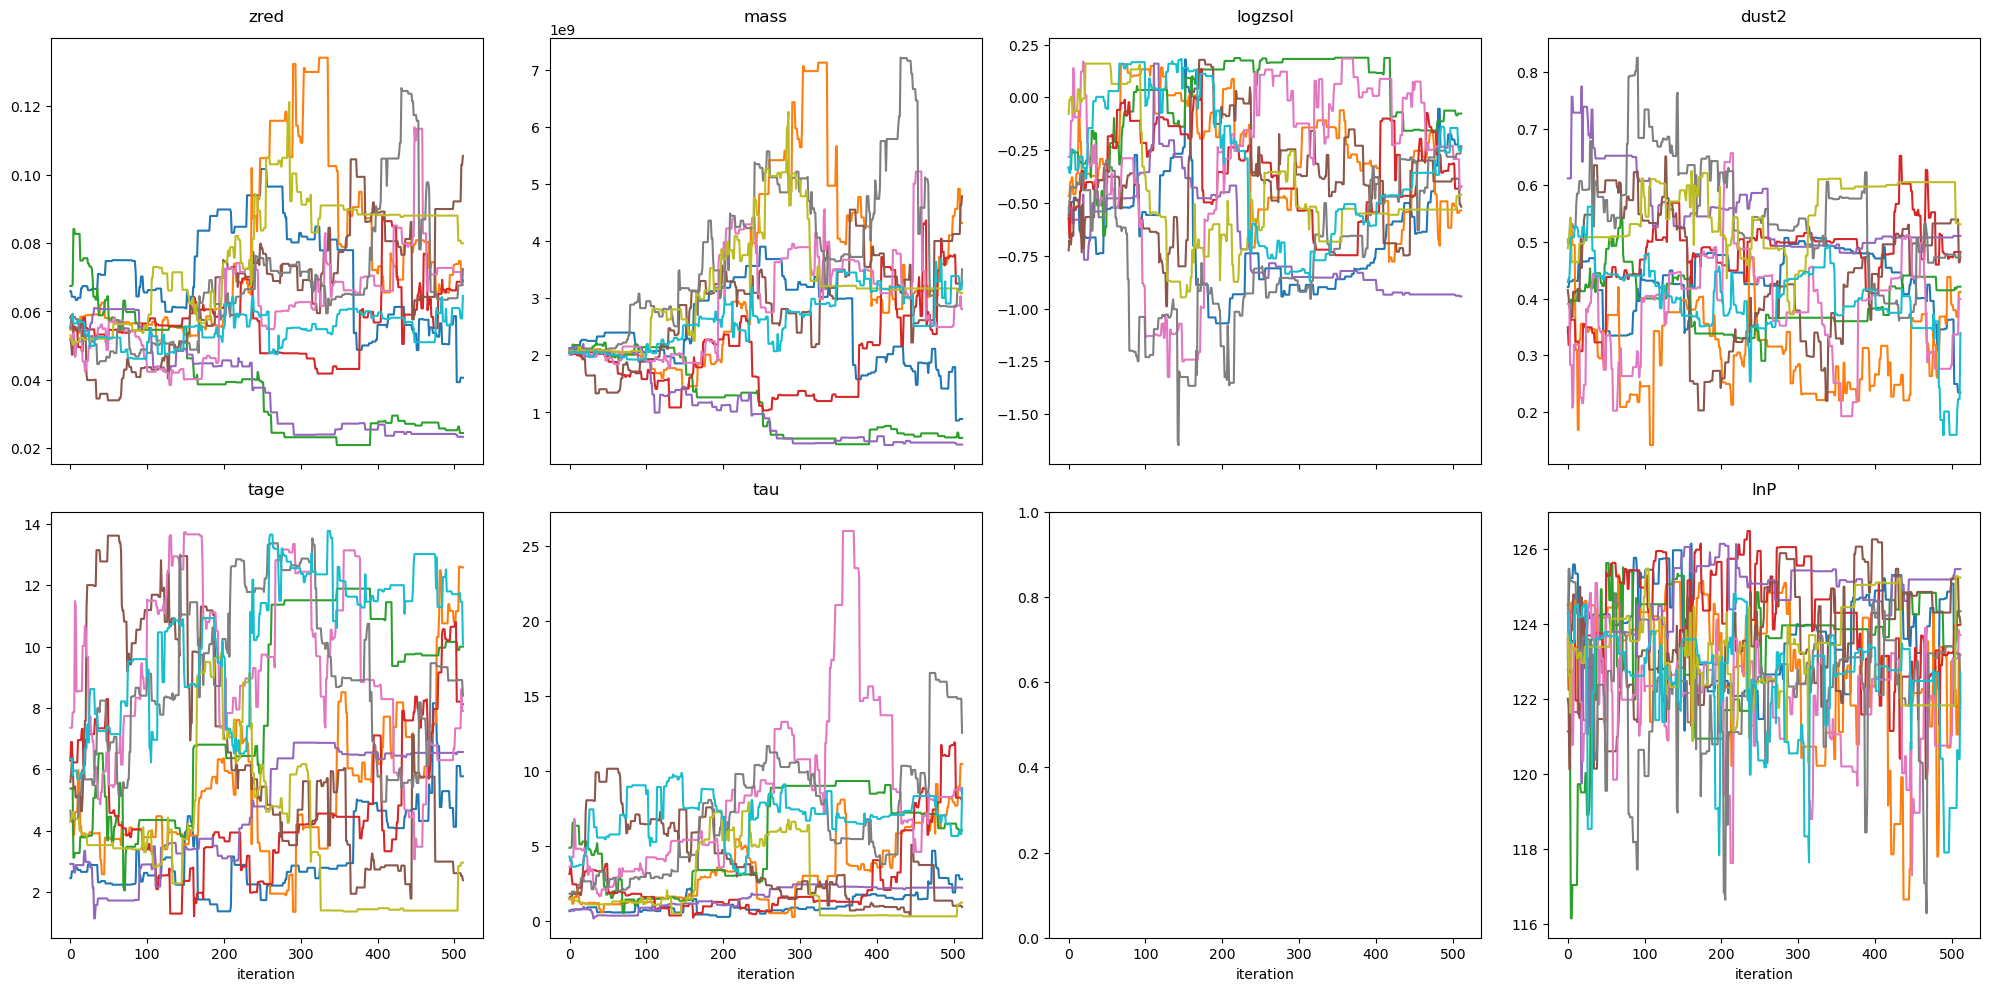

In [17]:
if results_type == "emcee":
    chosen = np.random.choice(result['run_params']["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))

In [19]:
run_params = {}
run_params["optimize"] = True
run_params["emcee"] = True
run_params["dynesty"] = False
run_params["nwalkers"] = 128
run_params["niter"] = 512
run_params["nburn"] = [16, 32, 64]

In [20]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])

if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1


# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)

IndexError: index 123 is out of bounds for axis 0 with size 64

Optimization value: [ 6.76028434e-02  2.23613433e+09 -2.27931551e-01  5.00560404e-01
  1.97790112e+00  5.25033173e-01]
MAP value: [ 6.76028434e-02  2.23613433e+09 -2.27931551e-01  5.00560404e-01
  1.97790112e+00  5.25033173e-01]


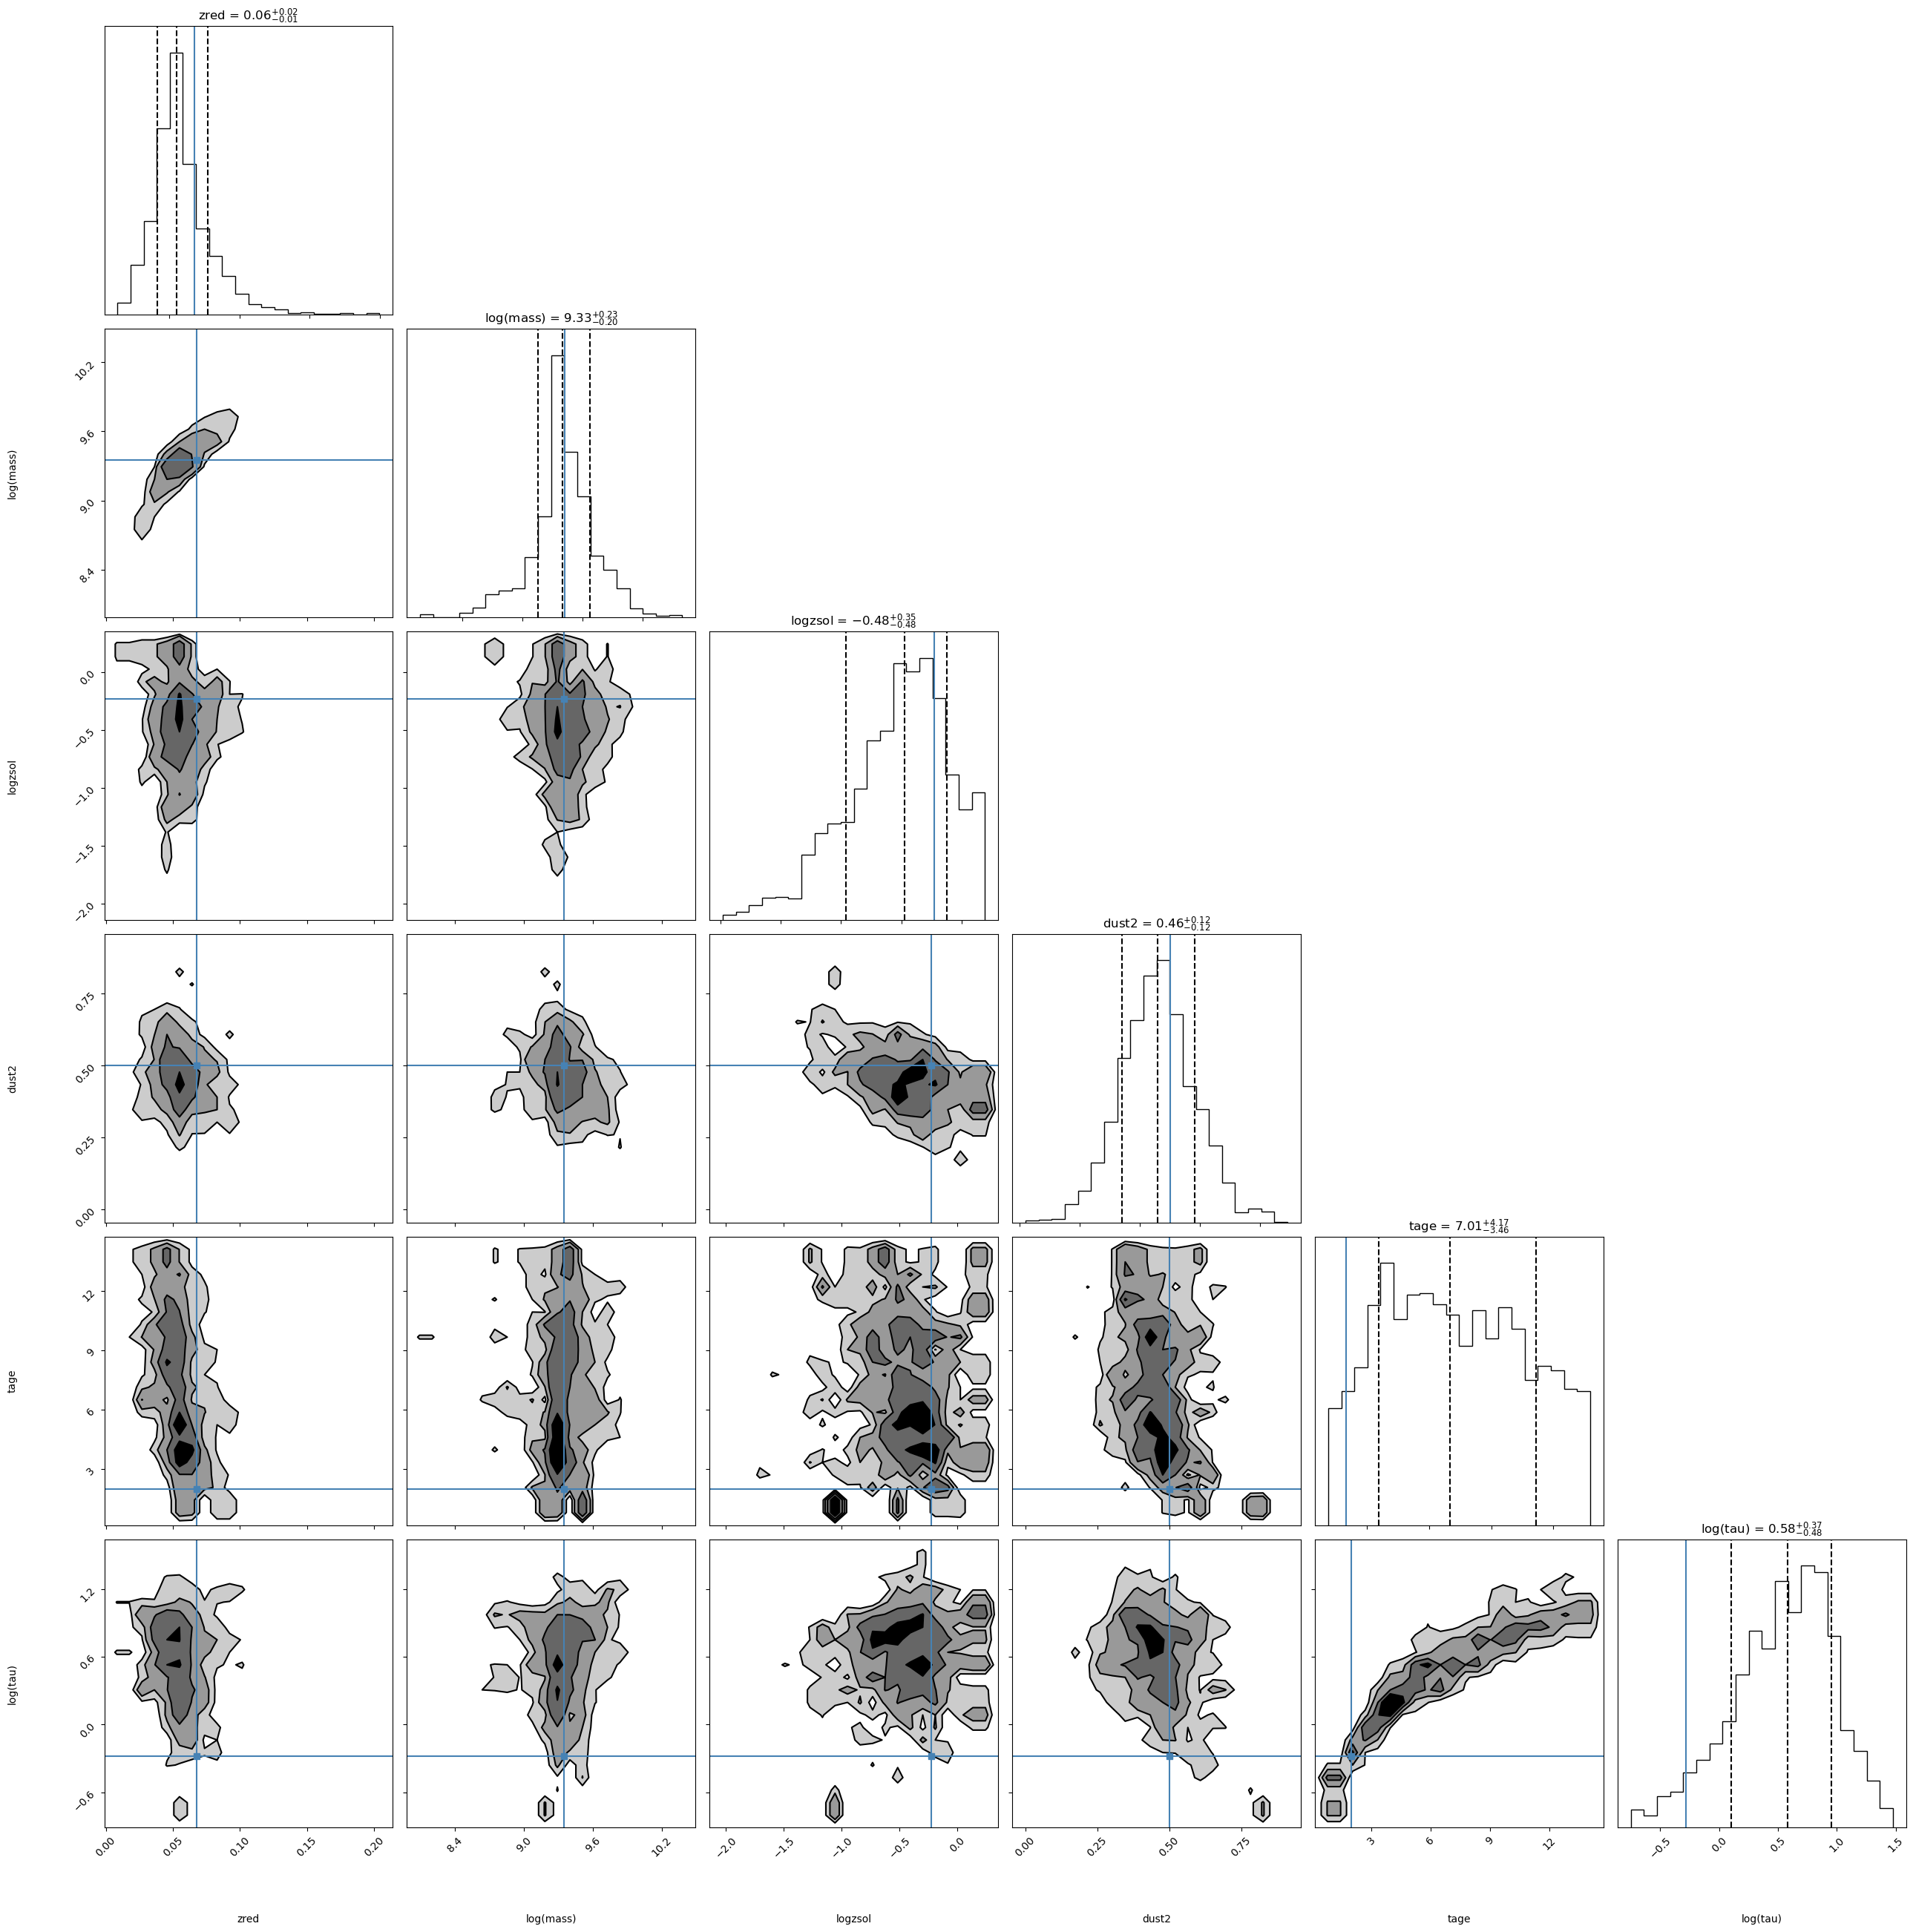

In [39]:
print('Optimization value: {}'.format(theta_max))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_max, 
                             fig=plt.subplots(6,6,figsize=(27,27))[0])

Are your results consistent with the fit from Chang et al.? (You can look up their values in the [output catalog](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html)). 

How similar do we expect them to be?

In [ ]:
# Space to work

#### Step 3: Comparing samples

Check the probability distribution of a single parameter (e.g., stellar mass) for a single galaxy and compare to the result from Chang et al. How different do you expect them to be? what does this tell you about the models you and Chang et al are fitting? You can try for a few different galaxies if you like to see if your conclusions are the same

In [ ]:
# Space to work

#### Step 4: Redshift

How did allowing the redshift as a free parameter change the results? Did you get the same mass? Is the redshift correct?

In [ ]:
# Space to work

# Section 2 

#### Step 1: Covariance

First lets look at the covariance of constrained parameters for one of your fits. Plot a corner plot of the prospector outputs, showing the 68% and 95% 2D contours. Remember, you can refer to the Prospector Example notebook on how to make a corner plot.

Are there any degeneracies between parameters in the fit? What does this mean?<br> How do the degeneracies change if we fix redshift or if we try to vary it?

In [ ]:
# Space to work

#### Step 2: Covariance matrix

The covariance matrix describes the uncertainties of parameters, and their covariance with each other. Make the covariance matrix for one of your fits and plot it.

Looking at the contour plot, was this a reasonable thing to do? i.e. Is your covariance matrix a good descriptor of your posterior

In [15]:
# Space to work

#### Step 3: Covariance of magnitude errors

So far, Prospector has assumed the uncertainties in the magnitudes/fluxes are independent of each other. In practice this might not be true. For this excercise, assume the correlation between the flux in each band is X%.

Plot the covariance matrix, with and without the correlated errors.

In [ ]:
# Space to work

Re-compute the goodness of fit with the correlated errors. <br>
Did the goodness-of-fit get worse or better, why?

In [ ]:
# Space to work

# Section 3 

#### Estimating the uncertainties

For this section, we will use the output catalogs, since running prospector on all 800000 galaxies would be a waste of computing for this class.

Plot a histogram of a given measured quantity (stellar mass, redshift, etc). Choose the range and bin size appropriately so that we can see the full distribution.

In [ ]:
# Space to work

There are a limited number of objects in each histogram bin. Add shot, or Poisson, noise to the histogram bars to show this. These will be your "analytic" error bars.

Now split the data into N subsets and compute the jackknife covarinace of the histogram bins.

* How does it compare to the analytic errors?
* Are the bins independent?
* What happens if you make N very large or very small?


In [16]:
# Space to work

Now repeat this excercise, replacing the histogram with a calculation of the mean stellar mass as a function of redshift (i.e. split the data into redshift bins, and compute the mean mass in each).

Use Jackknife to get the errors. How do these compare with the standard error of the mean?

In [ ]:
# Space to work